In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
from matplotlib import pyplot as plt
from sklearn import metrics

## Implementacja neuronu

In [54]:
from abc import ABC, abstractmethod
import logging

class Neuron(ABC):
    def __init__(self, weights: list) -> None:
        self.weights = weights
        if len(weights) < 2:
            logging.warning("Less than 2 weights. Are you sure?")
    
    def __repr__(self) -> str:
        return self.name() + "(" + str(self.weights) + ")"
            
    @abstractmethod
    def evaluate(self, input: list) -> float:
        pass
    
    @abstractmethod
    def name(self) -> str:
        pass
    
    def add_one(l: list) -> list:
        tmp = [1]
        tmp.extend(l)
        return tmp
    
    def dot(a: list, b: list) -> float:
        tmp = min(len(a), len(b))
        return np.dot(a[:tmp], b[:tmp])

    
# pierwsza waga to waga biasu
class LinearNeuron(Neuron):
    def evaluate(self, input: list) -> float:
        return Neuron.dot(self.weights, Neuron.add_one(input))
    
    def name(self) -> str:
        return "LinearNeuron"
        

class SigmoidNeuron(Neuron):
    def evaluate(self, input: list) -> float:
        x = Neuron.dot(self.weights, Neuron.add_one(input))
        return math.e ** x / (1 + math.e ** x)
    
    def name(self) -> str:
        return "SigmoidNeuron"

# tests

assert Neuron.dot([2,3], [5]) == 10
assert Neuron.dot([2,3], [4,5,6]) == 23

linearneuron = LinearNeuron([1,2,3])
assert linearneuron.evaluate([1,2,3]) == 9
assert linearneuron.evaluate([2,3]) == 14

sigmoidneuron = SigmoidNeuron([1, 2])
assert sigmoidneuron.evaluate([1]) == math.e ** 3 / (1 + math.e ** 3)
print(linearneuron)
print(sigmoidneuron)

LinearNeuron([1, 2, 3])
SigmoidNeuron([1, 2])


## Implementacja warstwy

In [55]:
class Layer(ABC):
    def __init__(self) -> None:
        self.neurons = []
    
    @abstractmethod
    def __init__(self, num: int, weights: list) -> None:
        pass
        
    def addNeuron(self, neuron: Neuron) -> None:
        self.neurons.append(neuron)
        
    def evaluate(self, input: list) -> list:
        return [neuron.evaluate(input) for neuron in self.neurons]
    
    def __repr__(self) -> str:
        return "Layer(" + str(self.neurons) + ")"
    

class LinearLayer(Layer):
    def __init__(self, num: int, weights: list) -> None:
        assert len(weights) == num, "Invalid matrix dimension"
        self.neurons = [LinearNeuron(w) for w in weights]
    
class SigmoidLayer(Layer):
    def __init__(self, num: int, weights: list) -> None:
        assert len(weights) == num, "Invalid matrix dimension"
        self.neurons = [SigmoidNeuron(w) for w in weights]

# tests
layer1 = LinearLayer(1, [[1, 2]])
assert layer1.evaluate([5]) == [11]
layer1.addNeuron(LinearNeuron([2, 3]))
assert layer1.evaluate([5]) == [11, 17]

layer2 = LinearLayer(2, [[1,2], [2, 3]])
assert layer2.evaluate([5]) == [11, 17]
print(layer2)

Layer([LinearNeuron([1, 2]), LinearNeuron([2, 3])])


## Implementacja sieci

In [56]:
class Network:
    def __init__(self) -> None:
        self.layers = []
    
    def __repr__(self) -> str:
        return "Network(" + str(self.layers) + ")"
    
    def __init__(self, layer_types: list, weights: list) -> None:
        assert len(layer_types) == len(weights), "Invalid matrix dimension"
        self.layers = []
        for i in range(len(weights)):
            if layer_types[i] == "sigmoid":
                self.addLayerBack(SigmoidLayer(len(weights[i]), weights[i]))
            elif layer_types[i] == "linear":
                self.addLayerBack(LinearLayer(len(weights[i]), weights[i]))
            else:
                logging.error("Invalid layer type")
        
    def addLayerBack(self, layer: Layer) -> None:
        self.layers.append(layer)
    
    def forward(self, x: list) -> list:
        input = x
        for layer in self.layers:
            out = []
            for val in input:
                tmp = layer.evaluate(val)
                out.append(tmp)
            input = out
        return input

# tests
network = Network(["linear"], [[[1,2,3]]])
assert network.forward([[2,3]]) == [[14]]

network2 = Network(["linear"], [
        [[1,2], [2, 3]]
])
assert network2.forward([[5]]) == [[11, 17]]

# Zbiór square-simple

In [57]:
train_df = pd.read_csv('./mio1/regression/square-simple-training.csv', index_col=0)
test_df = pd.read_csv('./mio1/regression/square-simple-test.csv', index_col=0)

### jedna warstwa ukryta, 5 neuronów

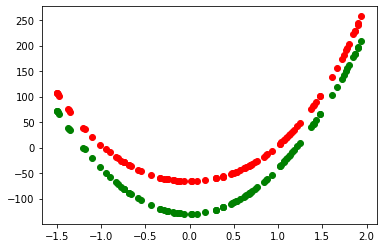

In [58]:
mlp = Network(["sigmoid", "linear"], [
    [
        [5, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [-5, 1]
    ],
    [
        [9800,-10000,0,0,0,10000]
    ]])
y_pred = mlp.forward(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

##### Wynik na zbiorze treningowym

In [59]:
metrics.mean_absolute_error(train_df['y'], y_pred)

49.39315589983348

##### Wynik na zbiorze testowym

In [60]:
y_pred = mlp.forward(np.expand_dims(test_df['x'], 1))
y_pred = np.squeeze(y_pred)
metrics.mean_absolute_error(test_df['y'], y_pred)

49.158191154537754

# Zbiór steps-large

In [61]:
train_df = pd.read_csv('./mio1/regression/steps-large-training.csv', index_col=0)
test_df = pd.read_csv('./mio1/regression/steps-large-test.csv', index_col=0)

### Jedna warstwa ukryta, 10 neuronów

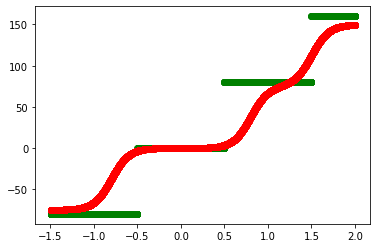

In [62]:
mlp = Network(["sigmoid", "linear"], [
    [
        [-8, 10],
        [-15, 10],
        [8, 10],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1]
    ],
    [
        [-75, 75, 75, 75, 0, 0, 0, 0, 0, 0, 0]
    ]])
y_pred = mlp.forward(np.expand_dims(train_df['x'], 1))
y_pred = np.squeeze(y_pred)
plt.scatter(train_df['x'], train_df['y'], color='green')
plt.scatter(train_df['x'], y_pred, color='red')

##### Wynik na zbiorze treningowym

In [63]:
metrics.mean_absolute_error(train_df['y'], y_pred)

19.285010695832717

##### Wynik na zbiorze testowym

In [64]:
y_pred = mlp.forward(np.expand_dims(test_df['x'], 1))
y_pred = np.squeeze(y_pred)
metrics.mean_absolute_error(test_df['y'], y_pred)

19.104502371942342

### Dwie warstwy ukryte, po 5 neuronów każda

In [65]:
mlp = Network(["sigmoid", "sigmoid", "linear"], [
    [
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1]
    ],
    [
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1],
        [1, 1]
    ],
    [
        [-75, 75, 75, 75, 0, 0]
    ]])